Pour démarer la présentation : `jupyter nbconvert --config=Configuration.py Presentation.ipynb`

# Validation croisée ✅

Présenté par Alix ANNERAUD et Hugo TONDENIER.

# 1. Principe 🔍

Qu'est-ce que la validation croisée et pourquoi est-elle utile ?

## 📖 Définition

### 🤖 Réponse de ChatGPT 4o

La vérification croisée, aussi connue sous le nom de validation croisée, est une technique utilisée en machine learning pour évaluer la performance d'un modèle. L'objectif principal est de vérifier comment les résultats d'un modèle généré à partir d'un jeu de données donné vont généraliser sur un jeu de données indépendant.

## 🏃 Entraînement d'un modèle

<img style="height: 500px;display: block;margin-left: auto;margin-right: auto;" src="Model_training.svg" alt="Model_training.svg" />

## ✅ Validation croisée

### 👶 Approche naïve

```mermaid
sankey-beta

%% source,target,value
Donnees,Entrainement,90.0
Donnees,Validation,10.0
```

### 🔢 K-plis (K-fold)

<img style="height: 400px;display: block;margin-left: auto;margin-right: auto;" src="K_fold.svg" alt="Model_training.svg" />

- ✅ Production de K modèles.
- ✅ Utilisation de toutes les données.
- ✅ Réduction de la variance.
- ⚠️ Certains plis peuvent être biaisés.
- ❌ Augmentation du temps de calcul.

### 🔀 Shuffle split

Pour chaque itération, on mélange les données et on prend aléatoire un pourcentage de données pour l'entraînement et un autre pour la validation.
Les données ne doivent pas être toutes utilisées pour un pli.


- ✅ Production de K modèles.
- ✅ Evite le biais des plis.
- ⚠️ Certaines données peuvent être utilisées plusieurs fois / pas du tout.
- ❌ Augmentation du temps de calcul

# 2. Exemple 👀

## 📥 Chargement des données

In [29]:
from sklearn import datasets, metrics, svm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

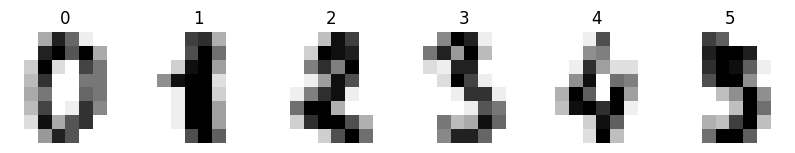

In [30]:
chiffres = datasets.load_digits()   # Importation du jeu de données

# Affichage des 6 premières images
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 5))
for ax, image, label in zip(axes, chiffres.images, chiffres.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title("%i" % label)

## 📊 Préparation des données

In [31]:
# "Aplatissement" des images (2D) en vecteurs de caractéristiques (1D)
n_samples = len(chiffres.images)
data = chiffres.images.reshape((n_samples, -1))

# Division en ensembles d'entraînement et de test
X_entrainement, X_test, y_entrainement, y_test = train_test_split(data, chiffres.target, test_size=0.3, shuffle=False)


## 📈 Regression logistique
montrer le réglage de l'hyperparamètre max_iter 30 est mieux que 1000 pour le train set et le test set définis ici  
remonter un mettre shuffle = True dans le test split  
agrandir réduire la taille du test set pour avoir plus de donnée d'entrainement 

In [32]:
# - Création et entraînement du modèle
clf = LogisticRegression(max_iter=1000) # max_iter est l'hyperparamètre que l'on veut régler
clf.fit(X_entrainement, y_entrainement)

# Prédiction du model sur le jeu de test
prediction = clf.predict(X_test)

# Calcul de la précision du modèle
precision = accuracy_score(y_test, prediction)
print("Précision: {:.2f}%".format(precision * 100))

Précision: 91.30%


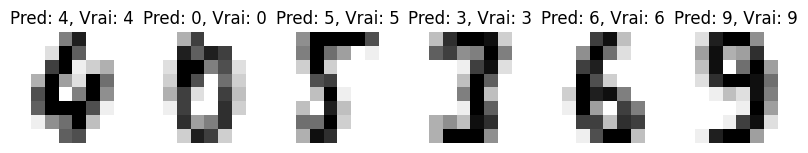

In [33]:
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 5))
for ax, image, prediction, true_label in zip(axes, X_test.reshape(-1, 8, 8), prediction, y_test):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Pred: {prediction}, Vrai: {true_label}')

In [34]:
# - Création et entraînement du modèle
clf = LogisticRegression(max_iter=30) # max_iter est l'hyperparamètre que l'on veut régler
clf.fit(X_entrainement, y_entrainement)

# Prédiction du model sur le jeu de test
prediction = clf.predict(X_test)

# Calcul de la précision du modèle
precision = accuracy_score(y_test, prediction)
print("Précision: {:.2f}%".format(precision * 100))

Précision: 91.85%


/home/alix_anneraud/.python_environment/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Intervention de la Validation Croisée

In [35]:

# Validation croisée de l'accuracy
accuracy_scores = cross_val_score(clf, data, chiffres.target, cv=5, scoring='accuracy')

print("Scores de précision pour chaque fold: ", accuracy_scores)
print("Moyenne: {:.2f}%".format(accuracy_scores.mean() * 100))

/home/alix_anneraud/.python_environment/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/alix_anneraud/.python_environment/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Scores de précision pour chaque fold:  [0.91388889 0.86944444 0.93871866 0.93314763 0.91086351]
Moyenne: 91.32%


/home/alix_anneraud/.python_environment/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Cas concret de recherche des paramètre avec un SVC  
la fonction gridsearchCV calcule des scores en utilisant la validation croisé pour une matrice de paramètres 

In [36]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Plus C est élevé, plus la régularisation est faible
    'gamma': [0.001, 0.01, 0.1, 1],  # Plus gamma est élevé, plus le modèle est complexe
    'kernel': ['rbf', 'poly', 'sigmoid']  # Types de noyaux à tester
}

# Création du modèle SVM avec GridSearchCV
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_entrainement, y_entrainement)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [37]:
# Affichage des meilleurs paramètres
print("Best parameters found: ", grid_search.best_params_)
best_svm = grid_search.best_estimator_

# Prédiction et évaluation sur l'ensemble de test
predictions = best_svm.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, predictions) * 100))

Best parameters found:  {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 97.04%


# Merci de votre attention 👏